# Population Segmentation with SageMaker

In this notebook, you'll employ two, unsupervised learning algorithms to do **population segmentation**. Population segmentation aims to find natural groupings in population data that reveal some feature-level similarities between different regions in the US.

Using **principal component analysis** (PCA) you will reduce the dimensionality of the original census data. Then, you'll use **k-means clustering** to assign each US county to a particular cluster based on where a county lies in component space. How each cluster is arranged in component space can tell you which US counties are most similar and what demographic traits define that similarity; this information is most often used to inform targeted, marketing campaigns that want to appeal to a specific group of people. This cluster information is also useful for learning more about a population by revealing patterns between regions that you otherwise may not have noticed.

### US Census Data

You'll be using data collected by the [US Census](https://en.wikipedia.org/wiki/United_States_Census), which aims to count the US population, recording demographic traits about labor, age, population, and so on, for each county in the US. The bulk of this notebook was taken from an existing SageMaker example notebook and [blog post](https://aws.amazon.com/blogs/machine-learning/analyze-us-census-data-for-population-segmentation-using-amazon-sagemaker/), and I've broken it down further into demonstrations and exercises for you to complete.

### Machine Learning Workflow

To implement population segmentation, you'll go through a number of steps:
* Data loading and exploration
* Data cleaning and pre-processing 
* Dimensionality reduction with PCA
* Feature engineering and data transformation
* Clustering transformed data with k-means
* Extracting trained model attributes and visualizing k clusters

These tasks make up a complete, machine learning workflow from data loading and cleaning to model deployment. Each exercise is designed to give you practice with part of the machine learning workflow, and to demonstrate how to use SageMaker tools, such as built-in data management with S3 and built-in algorithms.

---

First, import the relevant libraries into this SageMaker notebook. 

In [1]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

In [2]:
# sagemaker libraries
import boto3
import sagemaker

## Loading the Data from Amazon S3

This particular dataset is already in an Amazon S3 bucket; you can load the data by pointing to this bucket and getting a data file by name. 

> You can interact with S3 using a `boto3` client.

In [3]:
# boto3 client to get S3 data
s3_client = boto3.client('s3')
bucket_name='aws-ml-blog-sagemaker-census-segmentation'

Take a look at the contents of this bucket; get a list of objects that are contained within the bucket and print out the names of the objects. You should see that there is one file, 'Census_Data_for_SageMaker.csv'.

In [4]:
# get a list of objects in the bucket
obj_list=s3_client.list_objects(Bucket=bucket_name)

# print object(s)in S3 bucket
files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
    
print(files)

['Census_Data_for_SageMaker.csv']


In [5]:
# there is one file --> one key
file_name=files[0]

print(file_name)

Census_Data_for_SageMaker.csv


Retrieve the data file from the bucket with a call to `client.get_object()`.

In [6]:
# get an S3 object by passing in the bucket and file name
data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)

# what info does the object contain?
display(data_object)

{'ResponseMetadata': {'RequestId': 'A31759FA51EDECC4',
  'HostId': '2mroJxnCrGNrilZw/6S/t5swzrrbgutzDmKfiXyZGZ7L0hz8CMbX0LVsCRuSWHZXEQIXFr1L7f8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '2mroJxnCrGNrilZw/6S/t5swzrrbgutzDmKfiXyZGZ7L0hz8CMbX0LVsCRuSWHZXEQIXFr1L7f8=',
   'x-amz-request-id': 'A31759FA51EDECC4',
   'date': 'Sat, 24 Oct 2020 19:34:01 GMT',
   'last-modified': 'Wed, 12 Sep 2018 15:13:37 GMT',
   'etag': '"066d37f43f7762f1eb409b1660fe9763"',
   'accept-ranges': 'bytes',
   'content-type': 'text/csv',
   'content-length': '613237',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2018, 9, 12, 15, 13, 37, tzinfo=tzutc()),
 'ContentLength': 613237,
 'ETag': '"066d37f43f7762f1eb409b1660fe9763"',
 'ContentType': 'text/csv',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f56cc594ef0>}

In [7]:
# information is in the "Body" of the object
data_body = data_object['Body'].read()
print('Data type: ', type(data_body))

Data type:  <class 'bytes'>


This is a `bytes` datatype, which you can read it in using [io.BytesIO(file)](https://docs.python.org/3/library/io.html#binary-i-o).

In [11]:
# read in bytes data
data_stream = io.BytesIO(data_body)

# create a dataframe
counties_df = pd.read_csv(data_stream, header=0, delimiter=",") 
counties_df.head()
counties_df.shape

(3220, 37)

In [16]:
counties_df.to_excel('census.xlsx',header=True,index=True)

## Exploratory Data Analysis (EDA)

Now that you've loaded in the data, it is time to clean it up, explore it, and pre-process it. Data exploration is one of the most important parts of the machine learning workflow because it allows you to notice any initial patterns in data distribution and features that may inform how you proceed with modeling and clustering the data.

### EXERCISE: Explore data & drop any incomplete rows of data

When you first explore the data, it is good to know what you are working with. How many data points and features are you starting with, and what kind of information can you get at a first glance? In this notebook, you're required to use complete data points to train a model. So, your first exercise will be to investigate the shape of this data and implement a simple, data cleaning step: dropping any incomplete rows of data.

You should be able to answer the **question**: How many data points and features are in the original, provided dataset? (And how many points are left after dropping any incomplete rows?)

In [28]:
# print out stats about data

# drop any incomplete rows of data, and create a new df
clean_counties_df = None

print("Original shape of data: ", counties_df.shape)

clean_counties_df=counties_df.dropna(axis=0)

print("Shape of cleaned data: ", clean_counties_df.shape)

missing_data=counties_df[counties_df.isna().any(axis=1)]
print(missing_data)

Original shape of data:  (3220, 37)
Shape of cleaned data:  (3218, 37)
      CensusId   State   County  TotalPop  Men  Women  Hispanic  White  Black  \
548      15005  Hawaii  Kalawao        85   42     43       4.7   37.6    0.0   
2673     48301   Texas   Loving       117   74     43      35.0   41.0    0.0   

      Native  ...  Walk  OtherTransp  WorkAtHome  MeanCommute  Employed  \
548      0.0  ...  40.3         14.9         3.0          9.2        64   
2673    12.8  ...   8.1          0.0        16.1         25.4        62   

      PrivateWork  PublicWork  SelfEmployed  FamilyWork  Unemployment  
548          25.0        64.1          10.9         0.0           0.0  
2673         71.0        27.4           1.6         0.0          15.1  

[2 rows x 37 columns]


### EXERCISE: Create a new DataFrame, indexed by 'State-County'

Eventually, you'll want to feed these features into a machine learning model. Machine learning models need numerical data to learn from and not categorical data like strings (State, County). So, you'll reformat this data such that it is indexed by region and you'll also drop any features that are not useful for clustering.

To complete this task, perform the following steps, using your *clean* DataFrame, generated above:
1. Combine the descriptive columns, 'State' and 'County', into one, new categorical column, 'State-County'. 
2. Index the data by this unique State-County name.
3. After doing this, drop the old State and County columns and the CensusId column, which does not give us any meaningful demographic information.

After completing this task, you should have a DataFrame with 'State-County' as the index, and 34 columns of numerical data for each county. You should get a resultant DataFrame that looks like the following (truncated for display purposes):
```
                TotalPop	 Men	  Women	Hispanic	...
                
Alabama-Autauga	55221	 26745	28476	2.6         ...
Alabama-Baldwin	195121	95314	99807	4.5         ...
Alabama-Barbour	26932	 14497	12435	4.6         ...
...

```

In [33]:
# index data by 'State-County'
clean_counties_df.index= clean_counties_df[['State','County']].agg('-'.join,axis=1)

clean_counties_df.head

<bound method NDFrame.head of                        CensusId        State     County  TotalPop    Men  \
Alabama-Autauga            1001      Alabama    Autauga     55221  26745   
Alabama-Baldwin            1003      Alabama    Baldwin    195121  95314   
Alabama-Barbour            1005      Alabama    Barbour     26932  14497   
Alabama-Bibb               1007      Alabama       Bibb     22604  12073   
Alabama-Blount             1009      Alabama     Blount     57710  28512   
...                         ...          ...        ...       ...    ...   
Puerto Rico-Vega Baja     72145  Puerto Rico  Vega Baja     56858  27379   
Puerto Rico-Vieques       72147  Puerto Rico    Vieques      9130   4585   
Puerto Rico-Villalba      72149  Puerto Rico   Villalba     24685  12086   
Puerto Rico-Yabucoa       72151  Puerto Rico    Yabucoa     36279  17648   
Puerto Rico-Yauco         72153  Puerto Rico      Yauco     39474  19047   

                       Women  Hispanic  White  Black  Nat

In [36]:
# drop the old State and County columns, and the CensusId column
# clean df should be modified or created anew
clean_counties_new=clean_counties_df.drop(['State','County','CensusId'],axis=1)
clean_counties_new.shape

(3218, 34)

Now, what features do you have to work with?

In [37]:
# features
features_list = clean_counties_new.columns.values
print('Features: \n', features_list)

Features: 
 ['TotalPop' 'Men' 'Women' 'Hispanic' 'White' 'Black' 'Native' 'Asian'
 'Pacific' 'Citizen' 'Income' 'IncomeErr' 'IncomePerCap' 'IncomePerCapErr'
 'Poverty' 'ChildPoverty' 'Professional' 'Service' 'Office' 'Construction'
 'Production' 'Drive' 'Carpool' 'Transit' 'Walk' 'OtherTransp'
 'WorkAtHome' 'MeanCommute' 'Employed' 'PrivateWork' 'PublicWork'
 'SelfEmployed' 'FamilyWork' 'Unemployment']


## Visualizing the Data

In general, you can see that features come in a variety of ranges, mostly percentages from 0-100, and counts that are integer values in a large range. Let's visualize the data in some of our feature columns and see what the distribution, over all counties, looks like.

The below cell displays **histograms**, which show the distribution of data points over discrete feature ranges. The x-axis represents the different bins; each bin is defined by a specific range of values that a feature can take, say between the values 0-5 and 5-10, and so on. The y-axis is the frequency of occurrence or the number of county data points that fall into each bin. I find it helpful to use the y-axis values for relative comparisons between different features.

Below, I'm plotting a histogram comparing methods of commuting to work over all of the counties. I just copied these feature names from the list of column names, printed above. I also know that all of these features are represented as percentages (%) in the original data, so the x-axes of these plots will be comparable.

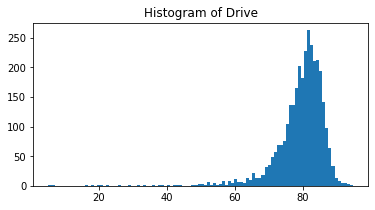

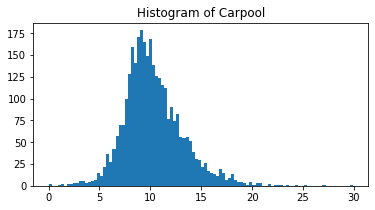

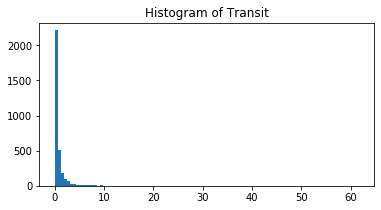

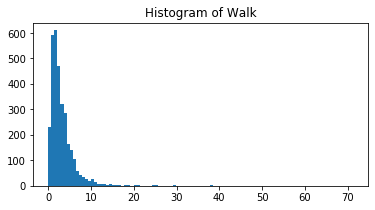

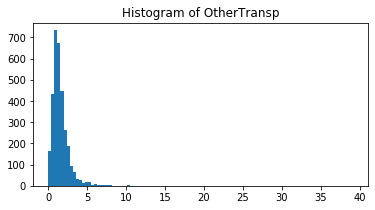

In [48]:
# transportation (to work)
transport_list = ['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp']
n_bins = 100 # can decrease to get a wider bin (or vice versa)

for column_name in transport_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(clean_counties_new[column_name],bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

### EXERCISE: Create histograms of your own

Commute transportation method is just one category of features. If you take a look at the 34 features, you can see data on profession, race, income, and more. Display a set of histograms that interest you!


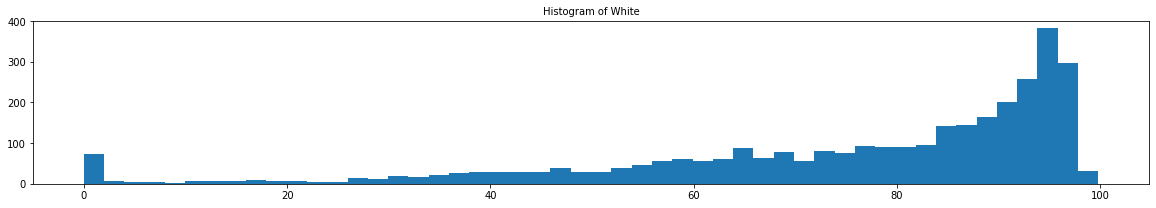

Average percentage of White people:  75.45124300807956


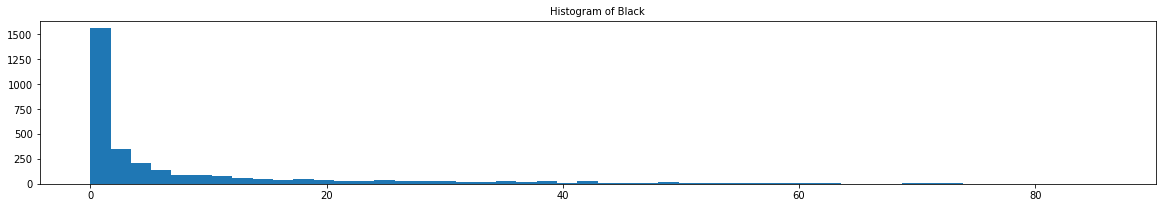

Average percentage of Black people:  8.670882535736483


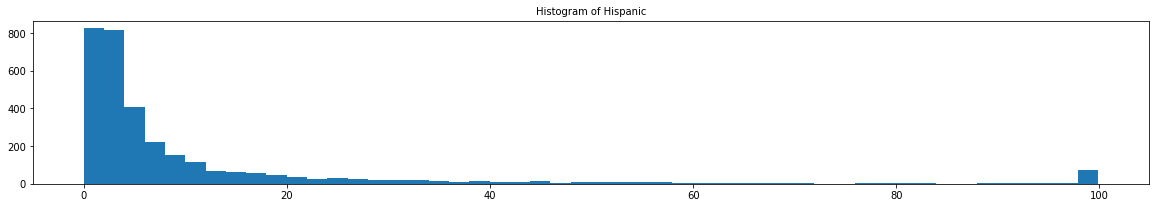

Average percentage of Hispanic people:  11.006028589185828


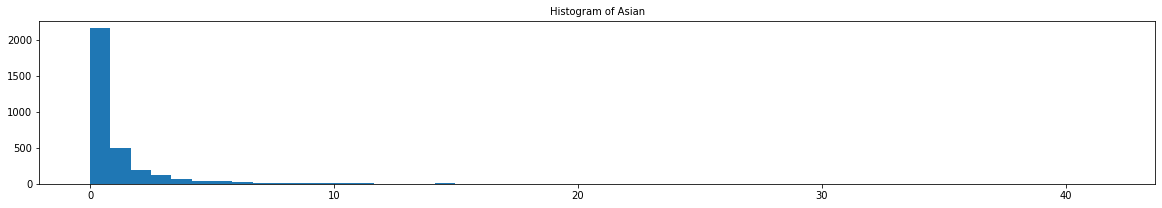

Average percentage of Asian people:  1.223244251087632


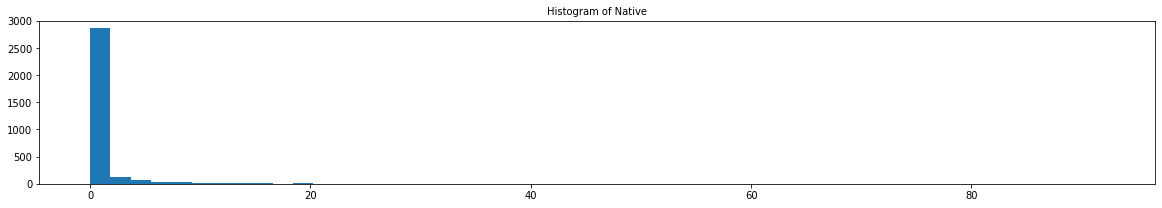

Average percentage of Native people:  1.720602858918583


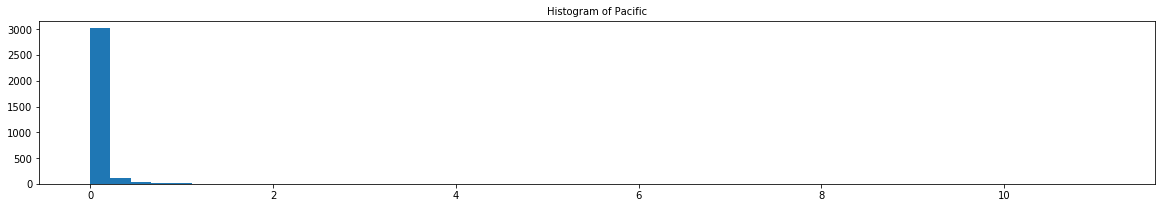

Average percentage of Pacific people:  0.07181479179614668


In [56]:
# create a list of features that you want to compare or examine
my_list = ['White','Black','Hispanic', 'Asian','Native', 'Pacific']
n_bins = 50 # define n_bins

# histogram creation code is similar to above
for column_name in my_list:
    ax=plt.subplots(figsize=(20,3))
    # get data by column_name and display a histogram
    ax = plt.hist(clean_counties_new[column_name], bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=10)
    plt.show()
    print('Average percentage of {} people: '.format(column_name),clean_counties_new[column_name].sum()/clean_counties_new.shape[0])

### EXERCISE: Normalize the data

You need to standardize the scale of the numerical columns in order to consistently compare the values of different features. You can use a [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to transform the numerical values so that they all fall between 0 and 1.

In [73]:
# scale numerical features into a normalized range, 0-1
# store them in this dataframe
from sklearn.preprocessing import MinMaxScaler

counties_scaled = pd.DataFrame(MinMaxScaler().fit_transform(clean_counties_new.astype(float)))
counties_scaled.index=clean_counties_new.index
counties_scaled.columns=clean_counties_new.columns
counties_scaled.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,0.005475,0.005381,0.005566,0.026026,0.759519,0.215367,0.004343,0.024038,0.0,0.006702,...,0.007022,0.033248,0.048387,0.552430,0.005139,0.750000,0.250000,0.150273,0.000000,0.208219
Alabama-Baldwin,0.019411,0.019246,0.019572,0.045045,0.832665,0.110594,0.006515,0.016827,0.0,0.024393,...,0.014045,0.035806,0.104839,0.549872,0.018507,0.884354,0.107616,0.158470,0.040816,0.205479
Alabama-Barbour,0.002656,0.002904,0.002416,0.046046,0.462926,0.543655,0.002172,0.009615,0.0,0.003393,...,0.025281,0.038363,0.043011,0.491049,0.001819,0.719388,0.248344,0.199454,0.010204,0.482192
Alabama-Bibb,0.002225,0.002414,0.002042,0.022022,0.746493,0.249127,0.004343,0.002404,0.0,0.002860,...,0.008427,0.038363,0.018817,0.611253,0.001754,0.804422,0.170530,0.183060,0.040816,0.227397
Alabama-Blount,0.005722,0.005738,0.005707,0.086086,0.880762,0.017462,0.003257,0.002404,0.0,0.006970,...,0.012640,0.010230,0.061828,0.767263,0.004751,0.892857,0.127483,0.114754,0.040816,0.210959


In [88]:
counties_scaled['White']

Alabama-Autauga          0.759519
Alabama-Baldwin          0.832665
Alabama-Barbour          0.462926
Alabama-Bibb             0.746493
Alabama-Blount           0.880762
                           ...   
Puerto Rico-Vega Baja    0.034068
Puerto Rico-Vieques      0.029058
Puerto Rico-Villalba     0.000000
Puerto Rico-Yabucoa      0.002004
Puerto Rico-Yauco        0.005010
Name: White, Length: 3218, dtype: float64

---
# Data Modeling


Now, the data is ready to be fed into a machine learning model!

Each data point has 34 features, which means the data is 34-dimensional. Clustering algorithms rely on finding clusters in n-dimensional feature space. For higher dimensions, an algorithm like k-means has a difficult time figuring out which features are most important, and the result is, often, noisier clusters.

Some dimensions are not as important as others. For example, if every county in our dataset has the same rate of unemployment, then that particular feature doesn’t give us any distinguishing information; it will not help t separate counties into different groups because its value doesn’t *vary* between counties.

> Instead, we really want to find the features that help to separate and group data. We want to find features that cause the **most variance** in the dataset!

So, before I cluster this data, I’ll want to take a dimensionality reduction step. My aim will be to form a smaller set of features that will better help to separate our data. The technique I’ll use is called PCA or **principal component analysis**

## Dimensionality Reduction

PCA attempts to reduce the number of features within a dataset while retaining the “principal components”, which are defined as *weighted*, linear combinations of existing features that are designed to be linearly independent and account for the largest possible variability in the data! You can think of this method as taking many features and combining similar or redundant features together to form a new, smaller feature set.

We can reduce dimensionality with the built-in SageMaker model for PCA.

## First Using Simple scikitlearn's builtin pca library:

In [93]:
from sklearn.decomposition import PCA

pca=PCA(n_components=33)

pca.fit(counties_scaled.values.astype('float32'))
transformed = pca.transform(counties_scaled.values)

In [105]:
#transformed.columns=counties_scaled.columns
transformed=pd.DataFrame(transformed)
transformed.index=counties_scaled.index
transformed.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
Alabama-Autauga,-0.060274,-0.160527,0.088356,0.120480,-0.010823,-0.040452,-0.025895,-0.113613,0.100115,-0.002478,...,0.009066,-0.005362,0.001727,-0.001131,0.000513,0.000419,0.000938,-0.000317,-0.000257,-0.000007
Alabama-Baldwin,-0.149684,-0.185968,0.145744,-0.023092,-0.068676,-0.051574,-0.048137,-0.054537,-0.029417,0.088121,...,0.008561,0.007429,-0.013380,-0.001665,-0.001133,0.000696,-0.000936,0.000393,0.000034,-0.000640
Alabama-Barbour,0.506202,-0.296662,-0.146257,0.297830,0.093111,0.065246,-0.107730,0.061642,0.087168,0.059830,...,0.041976,-0.020707,0.012084,0.002764,0.000716,-0.000276,-0.000902,0.000323,0.000626,-0.000040
Alabama-Bibb,0.069224,-0.190861,-0.224401,0.011757,0.283526,-0.017870,0.092053,-0.019079,0.017373,-0.058940,...,0.008792,-0.015579,0.002707,-0.000519,-0.001161,-0.000423,-0.000918,0.000381,0.000377,-0.000004
Alabama-Blount,-0.091030,-0.254404,-0.022713,-0.193824,0.100741,-0.209944,0.005100,0.017108,0.099364,0.032574,...,0.039246,-0.013300,0.006166,0.000626,-0.000151,0.000482,-0.001289,-0.000668,0.000245,0.000697


In [195]:
pca.singular_values_

array([19.592175  , 13.035976  , 11.718242  , 10.180058  ,  7.9913106 ,
        7.695218  ,  6.3925133 ,  5.9809747 ,  5.578647  ,  5.0189624 ,
        4.541034  ,  4.3457394 ,  4.189018  ,  3.6967018 ,  3.5731423 ,
        3.395281  ,  3.0175886 ,  2.806798  ,  2.6954758 ,  2.385602  ,
        2.2966337 ,  2.1662548 ,  1.7783777 ,  1.595798  ,  1.5100453 ,
        1.4084798 ,  0.4029003 ,  0.12699893,  0.09483209,  0.03556776,
        0.03452111,  0.03088388,  0.0271024 ], dtype=float32)

### Roles and Buckets

> To create a model, you'll first need to specify an IAM role, and to save the model attributes, you'll need to store them in an S3 bucket.

The `get_execution_role` function retrieves the IAM role you created at the time you created your notebook instance. Roles are essentially used to manage permissions and you can read more about that [in this documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html). For now, know that we have a FullAccess notebook, which allowed us to access and download the census data stored in S3.

You must specify a bucket name for an S3 bucket in your account where you want SageMaker model parameters to be stored. Note that the bucket must be in the same region as this notebook. You can get a default S3 bucket, which automatically creates a bucket for you and in your region, by storing the current SageMaker session and calling `session.default_bucket()`.

In [89]:
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::993972676715:role/service-role/AmazonSageMaker-ExecutionRole-20201023T023613


In [90]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-us-east-1-993972676715



## Define a PCA Model

To create a PCA model, I'll use the built-in SageMaker resource. A SageMaker estimator requires a number of parameters to be specified; these define the type of training instance to use and the model hyperparameters. A PCA model requires the following constructor arguments:

* role: The IAM role, which was specified, above.
* train_instance_count: The number of training instances (typically, 1).
* train_instance_type: The type of SageMaker instance for training.
* num_components: An integer that defines the number of PCA components to produce.
* sagemaker_session: The session used to train on SageMaker.

Documentation on the PCA model can be found [here](http://sagemaker.readthedocs.io/en/latest/pca.html).

Below, I first specify where to save the model training data, the `output_path`.

In [107]:
# define location to store model artifacts
prefix = 'counties'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-east-1-993972676715/counties/


In [108]:
# define a PCA model
from sagemaker import PCA

# this is current features - 1
# you'll select only a portion of these to use, later
N_COMPONENTS=33

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)


### Convert data into a RecordSet format

Next, prepare the data for a built-in model by converting the DataFrame to a numpy array of float values.

The *record_set* function in the SageMaker PCA model converts a numpy array into a **RecordSet** format that is the required format for the training input data. This is a requirement for _all_ of SageMaker's built-in models. The use of this data type is one of the reasons that allows training of models within Amazon SageMaker to perform faster, especially for large datasets.

In [109]:
# convert df to np array
train_data_np = counties_scaled.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)

In [237]:
train_data_np

array([[0.00547453, 0.00538076, 0.00556558, ..., 0.15027322, 0.        ,
        0.20821919],
       [0.0194114 , 0.01924648, 0.01957154, ..., 0.15846995, 0.04081633,
        0.20547946],
       [0.00265637, 0.00290402, 0.00241591, ..., 0.19945355, 0.01020408,
        0.48219177],
       ...,
       [0.00243253, 0.00241648, 0.00244811, ..., 0.3579235 , 0.02040816,
        0.70958906],
       [0.00358752, 0.0035412 , 0.0036325 , ..., 0.19945355, 0.        ,
        0.6657534 ],
       [0.00390581, 0.0038241 , 0.00398515, ..., 0.12021858, 0.        ,
        0.74246573]], dtype=float32)

## Train the model

Call the fit function on the PCA model, passing in our formatted, training data. This spins up a training instance to perform the training job.

Note that it takes the longest to launch the specified training instance; the fitting itself doesn't take much time.

In [110]:
%%time

# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-24 22:41:48 Starting - Starting the training job...
2020-10-24 22:41:50 Starting - Launching requested ML instances......
2020-10-24 22:43:01 Starting - Preparing the instances for training.........
2020-10-24 22:44:47 Downloading - Downloading input data...
2020-10-24 22:45:08 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/24/2020 22:45:32 INFO 140528649000768] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[10/24/2020 22:45:32 INFO 140528649000768] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'34', u'mini_batch_size': u'500', u'num_c

## Accessing the PCA Model Attributes

After the model is trained, we can access the underlying model parameters.

### Unzip the Model Details

Now that the training job is complete, you can find the job under **Jobs** in the **Training**  subsection  in the Amazon SageMaker console. You can find the job name listed in the training jobs. Use that job name in the following code to specify which model to examine.

Model artifacts are stored in S3 as a TAR file; a compressed file in the output path we specified + 'output/model.tar.gz'. The artifacts stored here can be used to deploy a trained model.

In [120]:
pca_SM.explained_variance_

AttributeError: 'PCA' object has no attribute 'explained_variance_'

In [122]:
# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console

training_job_name='pca-2020-10-24-22-41-48-550'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

counties/pca-2020-10-24-22-41-48-550/output/model.tar.gz


2304

### MXNet Array

Many of the Amazon SageMaker algorithms use MXNet for computational speed, including PCA, and so the model artifacts are stored as an array. After the model is unzipped and decompressed, we can load the array using MXNet.

You can take a look at the MXNet [documentation, here](https://aws.amazon.com/mxnet/).

In [126]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[1.7896362e-02 3.0864021e-02 3.2130770e-02 3.5486195e-02 9.4831578e-02
 1.2699370e-01 4.0288666e-01 1.4084760e+00 1.5100485e+00 1.5957943e+00
 1.7783760e+00 2.1662524e+00 2.2966361e+00 2.3856051e+00 2.6954880e+00
 2.8067985e+00 3.0175958e+00 3.3952675e+00 3.5731301e+00 3.6966958e+00
 4.1890211e+00 4.3457499e+00 4.5410376e+00 5.0189657e+00 5.5786467e+00
 5.9809699e+00 6.3925138e+00 7.6952214e+00 7.9913125e+00 1.0180052e+01
 1.1718245e+01 1.3035975e+01 1.9592180e+01]
<NDArray 33 @cpu(0)>, 'v': 
[[ 2.46869749e-03  2.56468095e-02  2.50773830e-03 ... -7.63925165e-02
   1.59879066e-02  5.04589686e-03]
 [-2.80601848e-02 -6.86634064e-01 -1.96283013e-02 ... -7.59587288e-02
   1.57304872e-02  4.95312130e-03]
 [ 3.25766727e-02  7.17300594e-01  2.40726061e-02 ... -7.68136829e-02
   1.62378680e-02  5.13597298e-03]
 ...
 [ 1.12151138e-01 -1.17030945e-02 -2.88011521e-01 ...  1.39890045e-01
  -3.09406728e-01 -6.34506866e-02]
 [ 2.99992133e-02 -3.13433539e-03 -7.63589665e-02 ...  4.17341813e-02


## PCA Model Attributes

Three types of model attributes are contained within the PCA model.

* **mean**: The mean that was subtracted from a component in order to center it.
* **v**: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
* **s**: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.
    
We are only interested in v and s. 

From s, we can get an approximation of the data variance that is covered in the first `n` principal components. The approximate explained variance is given by the formula: the sum of squared s values for all top n components over the sum over squared s values for _all_ components:

\begin{equation*}
\frac{\sum_{n}^{ } s_n^2}{\sum s^2}
\end{equation*}

From v, we can learn more about the combinations of original features that make up each principal component.


In [155]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())
spca=pca.singular_values_

## Data Variance

Our current PCA model creates 33 principal components, but when we create new dimensionality-reduced training data, we'll only select a few, top n components to use. To decide how many top components to include, it's helpful to look at how much **data variance** the components capture. For our original, high-dimensional data, 34 features captured 100% of our data variance. If we discard some of these higher dimensions, we will lower the amount of variance we can capture.

### Tradeoff: dimensionality vs. data variance

As an illustrative example, say we have original data in three dimensions. So, three dimensions capture 100% of our data variance; these dimensions cover the entire spread of our data. The below images are taken from the PhD thesis,  [“Approaches to analyse and interpret biological profile data”](https://publishup.uni-potsdam.de/opus4-ubp/frontdoor/index/index/docId/696) by Matthias Scholz, (2006, University of Potsdam, Germany).

<img src='notebook_ims/3d_original_data.png' width=35% />

Now, you may also note that most of this data seems related; it falls close to a 2D plane, and just by looking at the spread of the data, we  can visualize that the original, three dimensions have some correlation. So, we can instead choose to create two new dimensions, made up of linear combinations of the original, three dimensions. These dimensions are represented by the two axes/lines, centered in the data. 

<img src='notebook_ims/pca_2d_dim_reduction.png' width=70% />

If we project this in a new, 2D space, we can see that we still capture most of the original data variance using *just* two dimensions. There is a tradeoff between the amount of variance we can capture and the number of component-dimensions we use to represent our data.

When we select the top n components to use in a new data model, we'll typically want to include enough components to capture about 80-90% of the original data variance. In this project, we are looking at generalizing over a lot of data and we'll aim for about 80% coverage.

**Note**: The _top_ principal components, with the largest s values, are actually at the end of the s DataFrame. Let's print out the s values for the top n, principal components.

In [156]:
# looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  # 33-n

# print a selection of s
print(s.iloc[start_idx:, :])
print(spca[0:5])

            0
28   7.991313
29  10.180052
30  11.718245
31  13.035975
32  19.592180
[19.592175  13.035976  11.718242  10.180058   7.9913106]


In [154]:
counties_scaled.to_csv('Scaled Counties.csv')
clean_counties_new.to_csv('Cleaned Counties.csv')

In [150]:
!pip install dill
import dill
with open('pca.pkl','rb') as file:
    pca_up=dill.load(file)
        


You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [152]:
pca_up.singular_values_

array([19.592175  , 13.035976  , 11.718242  , 10.180058  ,  7.9913106 ,
        7.695218  ,  6.3925133 ,  5.9809747 ,  5.578647  ,  5.0189624 ,
        4.541034  ,  4.3457394 ,  4.189018  ,  3.6967018 ,  3.5731423 ,
        3.395281  ,  3.0175886 ,  2.806798  ,  2.6954758 ,  2.385602  ,
        2.2966337 ,  2.1662548 ,  1.7783777 ,  1.595798  ,  1.5100453 ,
        1.4084798 ,  0.4029003 ,  0.12699893,  0.09483209,  0.03556776,
        0.03452111,  0.03088388,  0.0271024 ], dtype=float32)

### EXERCISE: Calculate the explained variance

In creating new training data, you'll want to choose the top n principal components that account for at least 80% data variance. 

Complete a function, `explained_variance` that takes in the entire array `s` and a number of top principal components to consider. Then return the approximate, explained variance for those top n components. 

For example, to calculate the explained variance for the top 5 components, calculate s squared for *each* of the top 5 components, add those up and normalize by the sum of *all* squared s values, according to this formula:

\begin{equation*}
\frac{\sum_{5}^{ } s_n^2}{\sum s^2}
\end{equation*}

> Using this function, you should be able to answer the **question**: What is the smallest number of principal components that captures at least 80% of the total variance in the dataset?

In [276]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    # your code here
    variance=np.square(s[N_COMPONENTS-n_top_components:]).sum()/np.square(s).sum()
    return variance
    
    
    


### Test Cell

Test out your own code by seeing how it responds to different inputs; does it return a reasonable value for the single, top component? What about for the top 5 components?

In [284]:
# test cell
n_top_components = 7# select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0    0.801672
dtype: float32


As an example, you should see that the top principal component accounts for about 32% of our data variance! Next, you may be wondering what makes up this (and other components); what linear combination of features make these components so influential in describing the spread of our data?

Below, let's take a look at our original features and use that as a reference.

In [186]:
# features
features_list = counties_scaled.columns.values
print('Features: \n', features_list)

Features: 
 ['TotalPop' 'Men' 'Women' 'Hispanic' 'White' 'Black' 'Native' 'Asian'
 'Pacific' 'Citizen' 'Income' 'IncomeErr' 'IncomePerCap' 'IncomePerCapErr'
 'Poverty' 'ChildPoverty' 'Professional' 'Service' 'Office' 'Construction'
 'Production' 'Drive' 'Carpool' 'Transit' 'Walk' 'OtherTransp'
 'WorkAtHome' 'MeanCommute' 'Employed' 'PrivateWork' 'PublicWork'
 'SelfEmployed' 'FamilyWork' 'Unemployment']


## Component Makeup

We can now examine the makeup of each PCA component based on **the weightings of the original features that are included in the component**. The following code shows the feature-level makeup of the first component.

Note that the components are again ordered from smallest to largest and so I am getting the correct rows by calling N_COMPONENTS-1 to get the top, 1, component.

In [212]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()


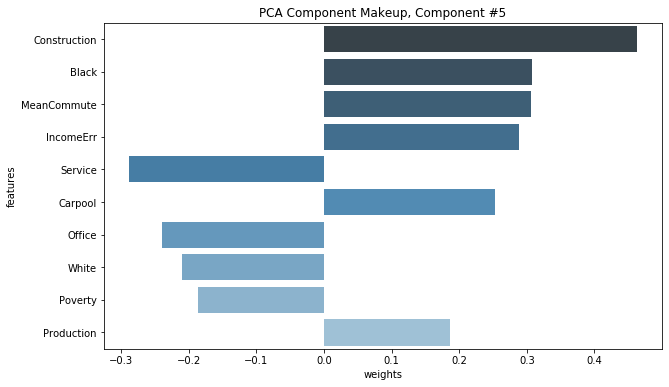

In [214]:
# display makeup of first component
num=5
display_component(v, counties_scaled.columns.values, component_num=num, n_weights=10)

# Deploying the PCA Model

We can now deploy this model and use it to make "predictions". Instead of seeing what happens with some test data, we'll actually want to pass our training data into the deployed endpoint to create principal components for each data point. 

Run the cell below to deploy/host this model on an instance_type that we specify.

In [215]:
%%time
# this takes a little while, around 7mins
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!CPU times: user 330 ms, sys: 9.67 ms, total: 340 ms
Wall time: 8min 33s


We can pass the original, numpy dataset to the model and transform the data using the model we created. Then we can take the largest n components to reduce the dimensionality of our data.

In [216]:
# pass np train data to the PCA model
train_pca = pca_predictor.predict(train_data_np)

In [217]:
# check out the first item in the produced training features
data_idx = 0
print(train_pca[data_idx])

label {
  key: "projection"
  value {
    float32_tensor {
      values: 0.0002009272575378418
      values: 0.0002455431967973709
      values: -0.0005782842636108398
      values: -0.0007815659046173096
      values: -0.00041911262087523937
      values: -0.0005133943632245064
      values: -0.0011316537857055664
      values: 0.0017268601804971695
      values: -0.005361668765544891
      values: -0.009066537022590637
      values: -0.008141040802001953
      values: -0.004735097289085388
      values: -0.00716288760304451
      values: 0.0003725700080394745
      values: -0.01208949089050293
      values: 0.02134685218334198
      values: 0.0009293854236602783
      values: 0.002417147159576416
      values: -0.0034637749195098877
      values: 0.01794189214706421
      values: -0.01639425754547119
      values: 0.06260128319263458
      values: 0.06637358665466309
      values: 0.002479255199432373
      values: 0.10011336207389832
      values: -0.1136140376329422
      values: 0

### EXERCISE: Create a transformed DataFrame

For each of our data points, get the top n component values from the list of component data points, returned by our predictor above, and put those into a new DataFrame.

You should end up with a DataFrame that looks something like the following:
```
                     c_1	     c_2	       c_3	       c_4	      c_5	   ...
Alabama-Autauga	-0.060274	0.160527	-0.088356	 0.120480	-0.010824	...
Alabama-Baldwin	-0.149684	0.185969	-0.145743	-0.023092	-0.068677	...
Alabama-Barbour	0.506202	 0.296662	 0.146258	 0.297829	0.093111	...
...
```

In [245]:
train_pca[0].label['projection'].float32_tensor.values

[0.0002009272575378418, 0.0002455431967973709, -0.0005782842636108398, -0.0007815659046173096, -0.00041911262087523937, -0.0005133943632245064, -0.0011316537857055664, 0.0017268601804971695, -0.005361668765544891, -0.009066537022590637, -0.008141040802001953, -0.004735097289085388, -0.00716288760304451, 0.0003725700080394745, -0.01208949089050293, 0.02134685218334198, 0.0009293854236602783, 0.002417147159576416, -0.0034637749195098877, 0.01794189214706421, -0.01639425754547119, 0.06260128319263458, 0.06637358665466309, 0.002479255199432373, 0.10011336207389832, -0.1136140376329422, 0.02589476853609085, 0.04045158624649048, -0.01082391943782568, 0.1204797774553299, -0.0883558839559555, 0.16052711009979248, -0.06027412414550781]

In [273]:
# create dimensionality-reduced data
def create_transformed_df(train_pca, counties_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param counties_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    # create a dataframe of component features, indexed by State-County
    
    transformed_df=pd.DataFrame()
    
    
    for data in train_pca:
        components_pca=data.label['projection'].float32_tensor.values
        transformed_df=transformed_df.append([list(components_pca)])
            
    transformed_df=transformed_df.iloc[:,N_COMPONENTS-n_top_components:]
    transformed_df.index=counties_scaled.index
    transformed_df.columns=['c_{}'.format(i) for i in range(n_top_components,0,-1)]
    return transformed_df.iloc[:,::-1]
    


Now we can create a dataset where each county is described by the top n principle components that we analyzed earlier. Each of these components is a linear combination of the original feature space. We can interpret each of these components by analyzing the makeup of the component, shown previously.

### Define the `top_n` components to use in this transformed data

Your code should return data, indexed by 'State-County' and with as many columns as `top_n` components.

You can also choose to add descriptive column names for this data; names that correspond to the component number or feature-level makeup.

In [364]:
## Specify top n
top_n = 8

# call your function and create a new dataframe
counties_transformed = create_transformed_df(train_pca, counties_scaled, n_top_components=top_n)

## TODO: Add descriptive column names
#Already done

# print result
counties_transformed.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8
Alabama-Autauga,-0.060274,0.160527,-0.088356,0.120480,-0.010824,0.040452,0.025895,-0.113614
Alabama-Baldwin,-0.149684,0.185969,-0.145743,-0.023092,-0.068677,0.051573,0.048137,-0.054537
Alabama-Barbour,0.506202,0.296662,0.146258,0.297829,0.093111,-0.065244,0.107730,0.061641
Alabama-Bibb,0.069224,0.190861,0.224402,0.011757,0.283526,0.017874,-0.092053,-0.019080
Alabama-Blount,-0.091030,0.254403,0.022714,-0.193824,0.100738,0.209945,-0.005099,0.017106


### Delete the Endpoint!

Now that we've deployed the mode and created our new, transformed training data, we no longer need the PCA endpoint.

As a clean up step, you should always delete your endpoints after you are done using them (and if you do not plan to deploy them to a website, for example).

In [275]:
# delete predictor endpoint
session.delete_endpoint(pca_predictor.endpoint)

---
# Population Segmentation 

Now, you’ll use the unsupervised clustering algorithm, k-means, to segment counties using their PCA attributes, which are in the transformed DataFrame we just created. K-means is a clustering algorithm that identifies clusters of similar data points based on their component makeup. Since we have ~3000 counties and 34 attributes in the original dataset, the large feature space may have made it difficult to cluster the counties effectively. Instead, we have reduced the feature space to 7 PCA components, and we’ll cluster on this transformed dataset.

### EXERCISE: Define a k-means model

Your task will be to instantiate a k-means model. A `KMeans` estimator requires a number of parameters to be instantiated, which allow us to specify the type of training instance to use, and the model hyperparameters. 

You can read about the required parameters, in the [`KMeans` documentation](https://sagemaker.readthedocs.io/en/stable/kmeans.html); note that not all of the possible parameters are required.


### Choosing a "Good" K

One method for choosing a "good" k, is to choose based on empirical data. A bad k would be one so *high* that only one or two very close data points are near it, and another bad k would be one so *low* that data points are really far away from the centers.

You want to select a k such that data points in a single cluster are close together but that there are enough clusters to effectively separate the data. You can approximate this separation by measuring how close your data points are to each cluster center; the average centroid distance between cluster points and a centroid. After trying several values for k, the centroid distance typically reaches some "elbow"; it stops decreasing at a sharp rate and this indicates a good value of k. The graph below indicates the average centroid distance for value of k between 5 and 12.

<img src='notebook_ims/elbow_graph.png' width=50% />

A distance elbow can be seen around 8 when the distance starts to increase and then decrease at a slower rate. This indicates that there is enough separation to distinguish the data points in each cluster, but also that you included enough clusters so that the data points aren’t *extremely* far away from each cluster.

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


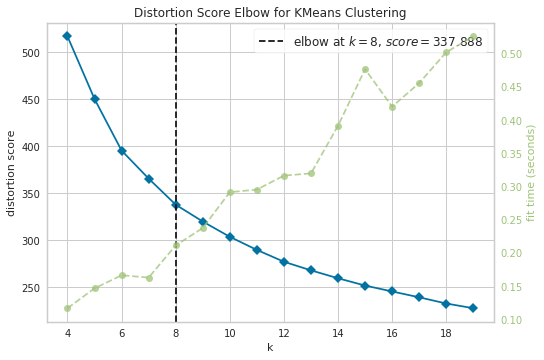

In [317]:
!pip install yellowbrick
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Generate synthetic dataset with 8 random clusters

# Instantiate the clustering model and visualizer
model = KMeans(8)
visualizer = KElbowVisualizer(model, k=(4,20))

visualizer.fit(counties_transformed.values)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [318]:
sse=[]
for k in range(4,16):
    km=KMeans(n_clusters=k)
    km=km.fit(counties_transformed)
    sse.append(km.inertia_)

Text(0.5, 1.0, 'elbow method for optimal k')

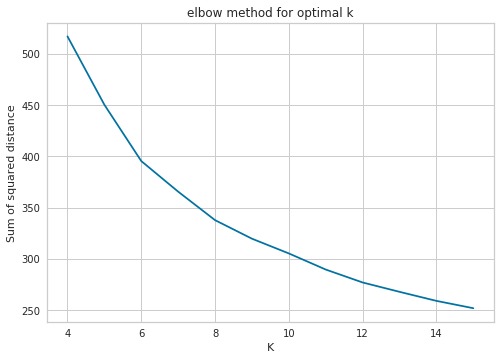

In [322]:
K=range(4,16)

plt.plot(K,sse,'bx-')
plt.xlabel('K')
plt.ylabel('Sum of squared distance')
plt.title('elbow method for optimal k')

In [337]:
# define a KMeans estimator
KMeans_popseg= sagemaker.KMeans(role,
                                train_instance_count=1,
                                train_instance_type='ml.m4.xlarge',
                                k=8,
                                output_path=output_path
                               )                     

### EXERCISE: Create formatted, k-means training data

Just as before, you should convert the `counties_transformed` df into a numpy array and then into a RecordSet. This is the required format for passing training data into a `KMeans` model.

In [291]:
# convert the transformed dataframe into record_set data
counties_transformed_np=counties_transformed.values.astype('float32')
formatted_clustering_data=KMeans_popseg.record_set(counties_transformed_np)

### EXERCISE: Train the k-means model

Pass in the formatted training data and train the k-means model.

In [338]:
%%time
# train kmeans
KMeans_popseg.fit(formatted_clustering_data)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-26 23:45:21 Starting - Starting the training job...
2020-10-26 23:45:23 Starting - Launching requested ML instances......
2020-10-26 23:46:37 Starting - Preparing the instances for training......
2020-10-26 23:47:42 Downloading - Downloading input data...
2020-10-26 23:48:09 Training - Downloading the training image...
2020-10-26 23:48:46 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[10/26/2020 23:48:40 INFO 140395635922752] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_d

### EXERCISE: Deploy the k-means model

Deploy the trained model to create a `kmeans_predictor`.


In [339]:
%%time
# deploy the model to create a predictor
kmeans_predictor = KMeans_popseg.deploy(initial_instance_count=1,
                                        instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------------!CPU times: user 369 ms, sys: 20.4 ms, total: 389 ms
Wall time: 10min 35s


### EXERCISE: Pass in the training data and assign predicted cluster labels

After deploying the model, you can pass in the k-means training data, as a numpy array, and get resultant, predicted cluster labels for each data point.

In [340]:
# get the predicted clusters for all the kmeans training data
cluster_info=kmeans_predictor.predict(counties_transformed_np)

## Exploring the resultant clusters

The resulting predictions should give you information about the cluster that each data point belongs to.

You should be able to answer the **question**: which cluster does a given data point belong to?

In [341]:
# print cluster info for first data point
data_idx = 1000

print('County is: ', counties_transformed.index[data_idx])
print()
print(cluster_info[data_idx])

County is:  Kentucky-Bourbon

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 1.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.11091388016939163
    }
  }
}



### Visualize the distribution of data over clusters

Get the cluster labels for each of our data points (counties) and visualize the distribution of points over each cluster.

In [342]:
# get all cluster labels
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]

In [343]:
# count up the points in each cluster
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()

print(cluster_df)

1.0    1204
7.0     505
3.0     391
4.0     375
2.0     285
0.0     214
5.0     153
6.0      91
Name: 0, dtype: int64


Now, you may be wondering, what do each of these clusters tell us about these data points? To improve explainability, we need to access the underlying model to get the cluster centers. These centers will help describe which features characterize each cluster.

Text(0, 0.5, 'Cluster Count')

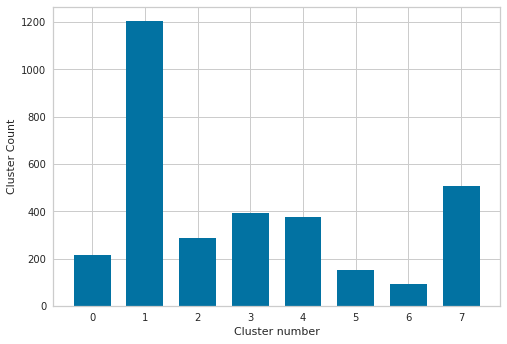

In [355]:
plt.hist(cluster_labels,bins=8,range=(-0.5,7.5),rwidth=0.7)
plt.xlabel('Cluster number')
plt.ylabel('Cluster Count')

### Delete the Endpoint!

Now that you've deployed the k-means model and extracted the cluster labels for each data point, you no longer need the k-means endpoint.

In [356]:
# delete kmeans endpoint
session.delete_endpoint(kmeans_predictor.endpoint)

---
# Model Attributes & Explainability

Explaining the result of the modeling is an important step in making use of our analysis. By combining PCA and k-means, and the information contained in the model attributes within a SageMaker trained model, you can learn about a population and remark on some patterns you've found, based on the data.

### EXERCISE: Access the k-means model attributes

Extract the k-means model attributes from where they are saved as a TAR file in an S3 bucket.

You'll need to access the model by the k-means training job name, and then unzip the file into `model_algo-1`. Then you can load that file using MXNet, as before.

In [361]:
# download and unzip the kmeans model file
# use the name model_algo-1
kmeans_training_job='kmeans-2020-10-26-23-45-20-878'

model_key = os.path.join(prefix, kmeans_training_job, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')


counties/kmeans-2020-10-26-23-45-20-878/output/model.tar.gz


2304

In [362]:
# get the trained kmeans params using mxnet
kmeans_model_params = mx.ndarray.load('model_algo-1')

print(kmeans_model_params)

[
[[ 0.29697055 -0.20459095 -0.13423632 -0.16067703  0.11985334 -0.11710003
  -0.07312045 -0.03933976]
 [-0.17694744  0.07010777  0.05890122 -0.07768667 -0.0466077  -0.00675677
  -0.01563561  0.00168572]
 [ 0.43173546  0.27569038  0.09746233  0.2963709   0.09848001 -0.07402264
   0.06054709  0.00130027]
 [-0.24672914 -0.3439551   0.10130008  0.07271998  0.02965834 -0.01472525
   0.08093873  0.0169105 ]
 [-0.13413084  0.05110701 -0.37348402  0.08871752 -0.00274407  0.0928015
  -0.00494826  0.01519252]
 [ 0.27073327 -0.22554976  0.10567258  0.2205778  -0.07589635  0.03569108
  -0.12644921 -0.00657632]
 [ 1.297157   -0.23420247 -0.17251627 -0.42040133 -0.1010442   0.11748923
   0.14132938  0.02119529]
 [ 0.05054854  0.14160833  0.05315099  0.01038074  0.03048748  0.03547499
  -0.00404507 -0.0152572 ]]
<NDArray 8x8 @cpu(0)>]


There is only 1 set of model parameters contained within the k-means model: the cluster centroid locations in PCA-transformed, component space.

* **centroids**: The location of the centers of each cluster in component space, identified by the k-means algorithm. 


In [365]:
# get all the centroids
cluster_centroids=pd.DataFrame(kmeans_model_params[0].asnumpy())
cluster_centroids.columns=counties_transformed.columns

display(cluster_centroids)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8
0,0.296971,-0.204591,-0.134236,-0.160677,0.119853,-0.117100,-0.073120,-0.039340
1,-0.176947,0.070108,0.058901,-0.077687,-0.046608,-0.006757,-0.015636,0.001686
2,0.431735,0.275690,0.097462,0.296371,0.098480,-0.074023,0.060547,0.001300
3,-0.246729,-0.343955,0.101300,0.072720,0.029658,-0.014725,0.080939,0.016911
4,-0.134131,0.051107,-0.373484,0.088718,-0.002744,0.092802,-0.004948,0.015193
5,0.270733,-0.225550,0.105673,0.220578,-0.075896,0.035691,-0.126449,-0.006576
6,1.297157,-0.234202,-0.172516,-0.420401,-0.101044,0.117489,0.141329,0.021195
7,0.050549,0.141608,0.053151,0.010381,0.030487,0.035475,-0.004045,-0.015257


### Visualizing Centroids in Component Space

You can't visualize 7-dimensional centroids in space, but you can plot a heatmap of the centroids and their location in the transformed feature space. 

This gives you insight into what characteristics define each cluster. Often with unsupervised learning, results are hard to interpret. This is one way to make use of the results of PCA + clustering techniques, together. Since you were able to examine the makeup of each PCA component, you can understand what each centroid represents in terms of the PCA components.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


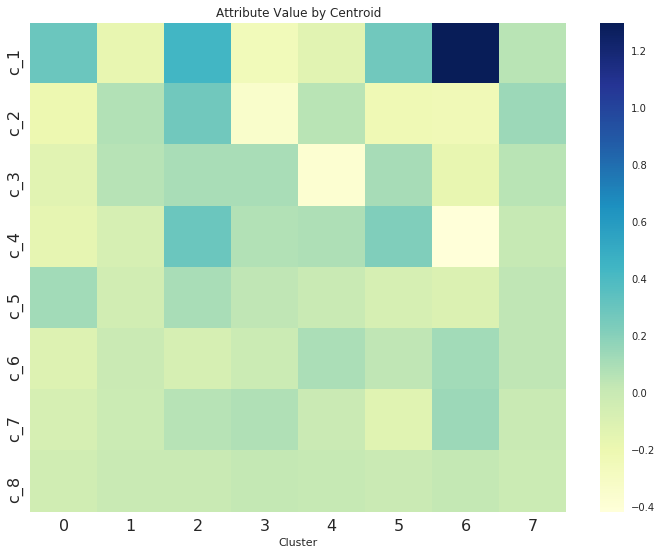

In [366]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

If you've forgotten what each component corresponds to at an original-feature-level, that's okay! You can use the previously defined `display_component` function to see the feature-level makeup.

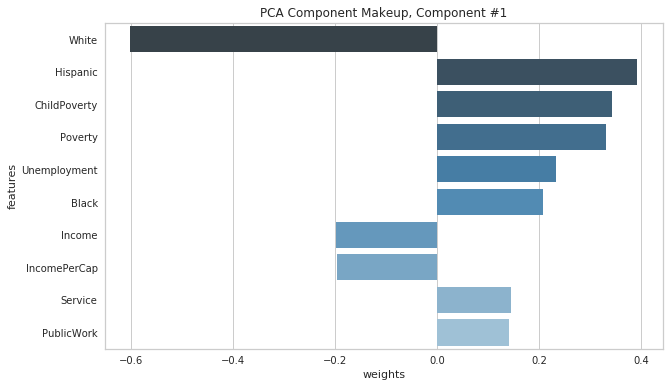

In [368]:
# what do each of these components mean again?
# let's use the display function, from above
component_num=1
display_component(v, counties_scaled.columns.values, component_num=component_num)

### Natural Groupings

You can also map the cluster labels back to each individual county and examine which counties are naturally grouped together.

In [369]:
# add a 'labels' column to the dataframe
counties_transformed['labels']=list(map(int, cluster_labels))

# sort by cluster label 0-6
sorted_counties = counties_transformed.sort_values('labels', ascending=True)
# view some pts in cluster 0
sorted_counties.head(20)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,labels
Nebraska-Dakota,0.183742,0.066737,-0.109757,-0.297124,0.140255,-0.386732,-0.095635,0.049569,0
Texas-Dallas,0.397573,0.137205,-0.502337,-0.040463,0.101993,-0.089102,0.016129,0.195028,0
Texas-Dawson,0.426020,-0.274150,-0.139726,-0.197539,0.141258,-0.209719,-0.106715,-0.135967,0
Oregon-Malheur,0.318095,-0.211421,0.131618,-0.137420,-0.052311,-0.090929,-0.051615,0.065890,0
Texas-Deaf Smith,0.506231,-0.231446,-0.208016,-0.397958,0.227496,-0.387688,0.017229,0.029795,0
California-Santa Barbara,0.218575,-0.251143,-0.383999,-0.104065,0.030078,-0.110928,-0.155083,0.077303,0
Nevada-Pershing,0.166404,-0.305433,0.100702,-0.014819,0.172082,-0.011361,-0.165944,-0.077745,0
Texas-Dallam,0.249605,-0.141741,0.008861,-0.303070,0.143592,-0.372193,-0.108100,-0.080506,0
Texas-DeWitt,0.150461,-0.152356,-0.130122,-0.070910,0.154330,-0.078556,0.061053,-0.121341,0
Texas-Dimmit,0.746769,-0.404573,-0.344278,-0.350672,0.069031,-0.230790,0.045101,-0.322669,0


You can also examine one of the clusters in more detail, like cluster 1, for example. A quick glance at the location of the centroid in component space (the heatmap) tells us that it has the highest value for the `comp_6` attribute. You can now see which counties fit that description.

In [373]:
# get all counties with label == 1
cluster=counties_transformed[counties_transformed['labels']==1]
cluster.head(30)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,labels
Alabama-Baldwin,-0.149684,0.185969,-0.145743,-0.023092,-0.068677,0.051573,0.048137,-0.054537,1
Alabama-Cherokee,-0.080311,0.104444,0.210828,-0.061823,0.027139,0.107847,-0.002206,0.051833,1
Alabama-Cullman,-0.136151,0.195683,0.087640,-0.169405,-0.027857,0.046839,0.026331,0.020815,1
Alabama-DeKalb,-0.011847,0.142680,0.125866,-0.215016,0.018603,-0.087450,0.014817,0.061139,1
Alabama-Jackson,-0.085892,0.172590,0.186306,-0.121960,-0.014199,0.026177,0.057882,0.044233,1
Alabama-Marion,-0.068600,0.144313,0.200314,-0.092458,-0.098375,0.025447,0.024279,0.005658,1
Alabama-St. Clair,-0.138401,0.265235,-0.060966,-0.072023,0.008413,0.117088,0.068735,-0.022803,1
Alabama-Winston,-0.020424,0.162348,0.291742,-0.145259,-0.071964,0.094209,0.002270,0.065504,1
Arizona-Yavapai,-0.032690,-0.035890,-0.038144,-0.077017,-0.116115,0.058567,-0.087076,0.034867,1
Arkansas-Baxter,-0.177526,0.094657,0.139024,-0.101276,-0.192770,-0.127944,0.045655,-0.006835,1


## Final Cleanup!

* Double check that you have deleted all your endpoints.
* I'd also suggest manually deleting your S3 bucket, models, and endpoint configurations directly from your AWS console.

You can find thorough cleanup instructions, [in the documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html).